In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from surprise import Dataset
from surprise import Reader
import matplotlib.pyplot as plt
from surprise import SVDpp
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import CoClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
import gzip
import math
sb.set_style('white')
%matplotlib inline

In [2]:
ratings = pd.read_csv('Data/book_ratings.csv')
ratings.head()

,user,item_id,rating
0,1,6264,7
1,1,4350,7
2,1,6252,5
3,1,202,9
4,1,6266,6


In [3]:
books = pd.read_csv('Data/item_info.csv')
books = books[['item_id','ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
books.head()

,item_id,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,1,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
1,2,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp
2,3,425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group
3,4,452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume
4,5,609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,1999,Three Rivers Press


In [4]:
Data = pd.merge(ratings, books, on='item_id')
Data.head()

,user,item_id,rating,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,1,6264,7,553280325,Something Wicked This Way Comes,Ray Bradbury,1983,Bantam
1,496,6264,8,553280325,Something Wicked This Way Comes,Ray Bradbury,1983,Bantam
2,676,6264,10,553280325,Something Wicked This Way Comes,Ray Bradbury,1983,Bantam
3,1842,6264,10,553280325,Something Wicked This Way Comes,Ray Bradbury,1983,Bantam
4,1,4350,7,345441184,The Mists of Avalon,MARION ZIMMER BRADLEY,2000,Del Rey


In [5]:
print('# of items : ', Data.item_id.count())
print('# of user : ', Data.user.count())
print('Mean of Ratings : ', Data.rating.mean())

# of items :  62656
# of user :  62656
Mean of Ratings :  7.9536995658835545


In [6]:
Data.groupby('Book-Title')['rating'].mean().sort_values(ascending = False).head()

Book-Title
Naked Justice          10.0
Amelia Writes Again    10.0
Vuelo Del Cisne        10.0
The Rain Catchers      10.0
Cool Shade             10.0
Name: rating, dtype: float64

In [7]:
Data.groupby('Book-Title')['rating'].count().sort_values(ascending = False).head(10)

Book-Title
Impossible Vacation                                                         160
The Rescue                                                                  145
Airframe                                                                    118
Tycoon'S Temptation (Silhouette Desire, No. 1414)                            89
Past Lives, Present Dreams: How to Use Reincarnation for Personal Growth     88
The Queen of the Damned (Vampire Chronicles (Paperback))                     86
Harry Potter and the Chamber of Secrets (Book 2)                             79
The Right Hand of Amon                                                       79
She's Come Undone (Oprah's Book Club (Paperback))                            77
The Deal                                                                     77
Name: rating, dtype: int64

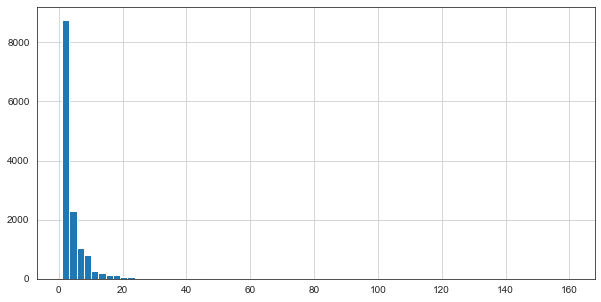

In [8]:
rs = pd.DataFrame(Data.groupby('Book-Title')['rating'].mean())
rs['num_ratings'] = Data.groupby('Book-Title')['rating'].count()
plt.figure(figsize=(10,5))
rs.num_ratings.hist(bins=70)
plt.show()

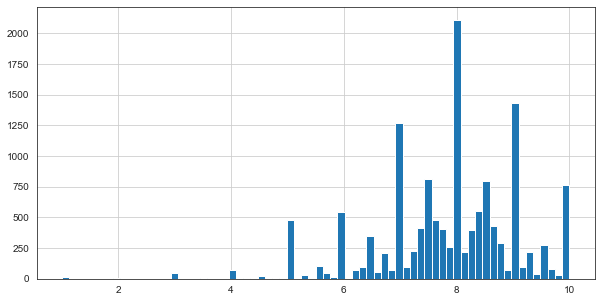

In [9]:
plt.figure(figsize=(10,5))
rs.rating.hist(bins=70)
plt.show()

In [10]:
d = Data[['item_id', 'user', 'rating']]
reader = Reader(rating_scale = (1,10))
data = Dataset.load_from_df(d, reader)
train , test = train_test_split(data,test_size = 0.2)

In [11]:
algorithm1 = SVDpp(n_factors = 20, n_epochs= 20,lr_all=0.01,init_std_dev= 0.005,verbose=False, reg_all=0.01)
algorithm2 = SVD(n_factors = 20, n_epochs= 20,lr_all=0.01,init_std_dev= 0.005,verbose=False, reg_all=0.01)
algorithm3 = KNNBasic()
algorithm1.fit(train)
algorithm2.fit(train)
algorithm3.fit(train)
pred1 = algorithm1.test(test)
pred2 = algorithm2.test(test)
pred3 = algorithm3.test(test)
accuracy.rmse(pred1)
accuracy.rmse(pred2)
accuracy.rmse(pred3)
accuracy.mae(pred1)
accuracy.mae(pred2)
accuracy.mae(pred3)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4657
RMSE: 1.4816
RMSE: 1.6456
MAE:  1.1130
MAE:  1.1280
MAE:  1.1920


1.1919964256759767

In [12]:
real_rating=[]
pred_rating=[]
real_rating2=[]
pred_rating2=[]
real_rating3=[]
pred_rating3=[]
for i in pred1:
    pui = pred1.pop()
    real_rating.append(pui.r_ui)
    pred_rating.append(pui.est)
for i in pred2:
    pui2 = pred2.pop()
    real_rating2.append(pui2.r_ui)
    pred_rating2.append(pui2.est)
for i in pred3:
    pui3 = pred3.pop()
    real_rating3.append(pui3.r_ui)
    pred_rating3.append(pui3.est)

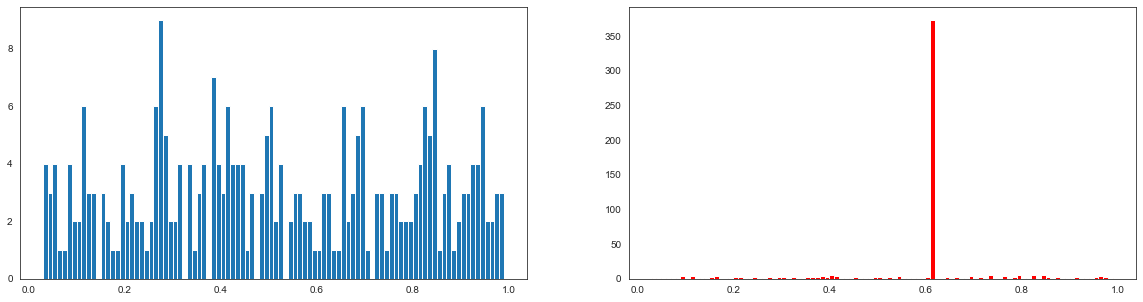

In [13]:
ratings_frame = pd.DataFrame({'Real_rating':real_rating,'Predicted_rating':pred_rating})
ratings_frame3 = pd.DataFrame({'Real_rating':real_rating3,'Predicted_rating':pred_rating3})
error = (abs((ratings_frame['Real_rating'] - ratings_frame['Predicted_rating'])) / ratings_frame['Real_rating'])*1e2
error3 = (abs((ratings_frame3['Real_rating'] - ratings_frame3['Predicted_rating'])) / ratings_frame3['Real_rating'])*1e2
fig, axes = plt.subplots(1,2,figsize=(20,5))
axes[0].hist(error,bins=[i/100 for i in range(3,100)])
axes[1].hist(error3,bins=[i/100 for i in range(3,100)], color = 'r')
plt.show()
fig.savefig('Book-Crossing.jpg', dpi=900)

In [14]:
d = pd.DataFrame(pred1, columns = ['user_id','item_id','real_ui','estimated_value','details'])
ranking = d.groupby('item_id')['estimated_value'].count().sort_values(ascending = False)
item_id = ranking.index
Data_to_np = Data.to_numpy()
Book_titles = []
for i in range(0,len(item_id)):
    Data_to_np[i,1] == item_id[i]
    Book_titles.append(Data_to_np[i,4])

Book_titles = list(set(Book_titles))
final = np.zeros((48,2), dtype = object)
for i in range(0, len(final)):
    final[i,0] = Book_titles[i]
    final[i,1] = item_id[i]
final = pd.DataFrame(final, columns=['Title', 'ID'])
final

,Title,ID
0,"The Subtle Knife (His Dark Materials, Book 2)",1003
1,The 10th Kingdom (Hallmark Entertainment Books),1614
2,Martian Chronicles,154
3,Brave New World,1180
4,Sideways Stories from Wayside School,965
5,Skipping Christmas,2155
6,Just Here Trying to Save a Few Lives : Tales o...,786
7,The Mists of Avalon,2475
8,Stone Butch Blues,2736
9,Love Always Remembers: A Book of Poems,2642


In [15]:
def parse(path):
    g = gzip.open(path, 'r')
    false = False
    true = True
    for l in g:
        yield eval (l)
def gen_toNumpy(gen):
    data = np.zeros((100000,5),dtype = object)
    for i in range(0,len(data)):
        for j in range(0,len(data[0])):
            r = next(gen)
            d = np.array(list(r.values()))
            data[i,j] = d[j]
    return data
good_reads = parse('Data/goodreads.gz')
d = gen_toNumpy(good_reads)

In [16]:
d[:,4] = d[:,4].astype(np.int)
DataCsv = np.zeros((len(d),len(d[0])), dtype = object)
for i in range(0,len(DataCsv)):
    if d[i,4] != 0:
        for j in range(0,len(DataCsv[0])):
            DataCsv[i,j] = d[i,j]
DataCsv = DataCsv[~np.all(DataCsv==0, axis=1)]

<ipython-input-16-4323406ac0c1>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d[:,4] = d[:,4].astype(np.int)


In [17]:
dt = pd.read_csv('Data/goodreads.csv')
dt = dt[['item_id', 'user', 'rating']]
reader = Reader(rating_scale=(1,5))
dt = Dataset.load_from_df(dt,reader)
train, test = train_test_split(dt, test_size=0.2)

In [18]:
algorithm1 = SVDpp(n_factors = 20, n_epochs= 20,lr_all=0.01,init_std_dev= 0.005,verbose=False, reg_all=0.01)
algorithm2 = SVD(n_factors = 20, n_epochs= 20,lr_all=0.01,init_std_dev= 0.005,verbose=False, reg_all=0.01)
algorithm3 = KNNBasic()
algorithm1.fit(train)
algorithm2.fit(train)
algorithm3.fit(train)
pred1 = algorithm1.test(test)
pred2 = algorithm2.test(test)
pred3 = algorithm3.test(test)
accuracy.rmse(pred1)
accuracy.rmse(pred2)
accuracy.rmse(pred3)
accuracy.mae(pred1)
accuracy.mae(pred2)
accuracy.mae(pred3)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8575
RMSE: 0.8577
RMSE: 0.9607
MAE:  0.6687
MAE:  0.6688
MAE:  0.7018


0.7017659611847625

In [19]:
real_rating=[]
pred_rating=[]
real_rating2=[]
pred_rating2=[]
real_rating3=[]
pred_rating3=[]
for i in pred1:
    pui = pred1.pop()
    real_rating.append(pui.r_ui)
    pred_rating.append(pui.est)
for i in pred2:
    pui2 = pred2.pop()
    real_rating2.append(pui2.r_ui)
    pred_rating2.append(pui2.est)
for i in pred3:
    pui3 = pred3.pop()
    real_rating3.append(pui3.r_ui)
    pred_rating3.append(pui3.est)

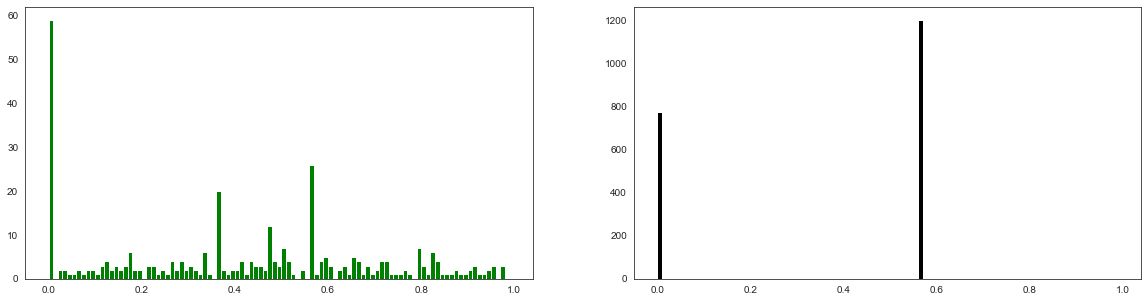

In [20]:
ratings_frame = pd.DataFrame({'Real_rating':real_rating,'Predicted_rating':pred_rating})
ratings_frame3 = pd.DataFrame({'Real_rating':real_rating3,'Predicted_rating':pred_rating3})
error = (abs((ratings_frame['Real_rating'] - ratings_frame['Predicted_rating'])) / ratings_frame['Real_rating'])*1e2
error3 = (abs((ratings_frame3['Real_rating'] - ratings_frame3['Predicted_rating'])) / ratings_frame3['Real_rating'])*1e2
fig, axes = plt.subplots(1,2,figsize=(20,5))
axes[0].hist(error,bins=[i/100 for i in range(0,100)], color = 'g')
axes[1].hist(error3,bins=[i/100 for i in range(0,100)], color = 'k')
plt.show()
fig.savefig('Goodreads.jpg', dpi=900)